# Example: Apple and Oranges Task using Q-Learning
Let's solve the Take Home Prelim 1 (THP1) `apples and oranges problem` using `Q-learning`.

### Background
In the `Q-learning` approach, we estimate the $Q(s,a)$ function through experimentation, where we update $Q(s,a)$ after each experiment using the update rule:

$$
\begin{equation*}
Q(s,a)\leftarrow{Q(s,a)}+\alpha\cdot\left(r+\gamma\cdot\max_{a^{\prime}}Q(s^{\prime},a^{\prime}) - Q(s,a)\right)
\end{equation*}
$$

The quantity $\alpha$ is the learning rate parameter, $r$ is the reward, $\gamma$ is the discount factor, $s^{\prime}$ and $a^{\prime}$ 
are the next state and action, respectively. Once we have the $Q(s, a)$ function, we can estimate the policy $\pi(s)$:

$$
\begin{equation*}
\pi(s) = \arg\max_{a}Q(s,a)
\end{equation*}
$$

## Setup
The computations in this examp,e are enabled by several external `Julia` packages and custom codes the teaching team has developed to work with these packages. To include this code, we [include](https://docs.julialang.org/en/v1/manual/code-loading/) the `Include.jl` file):

In [1]:
include("CHEME-5760-L13a-CodeLib.jl");

In [2]:
using Plots
using Colors

In [3]:
function rbf(x::Tuple{Int,Int},y::Tuple{Int,Int}; σ = 1.0)::Float64
    d = sqrt((x[1] - y[1])^2 + (x[2] - y[2])^2);
    return exp(-d/(2*σ^2))
end;

In [4]:
function U(x::Tuple{Int,Int}, α::Array{Float64,1})::Float64
    
    # get the apples, and oranges 
    apples = x[1];
    oranges = x[2];
    
    # compute the objective -
    utility = (apples^α[1])*(oranges^α[2]);
    
    # return -
    return utility;
end;

#### `Apples and Oranges` solution from THP1

In [5]:
αvec = [0.55, 0.45]; # coefficients
c = [0.98, 1.49]; # price of x1 and x2
optimal_apples = 28;
optimal_oranges = 15;
total_budget = 50.0;

## Task 1: Build the Rectangular Grid World Model
We encode the `rectangular grid world` using the `MyRectangularGridWorldModel` model, which we construct using a `build(...)` method. Let's set up the data for the `apples` and `oranges` world, i.e., set up the states, actions, and rewards and then construct the world model. 
* First, set values for the `number_of_rows` and `number_of_cols` variables, the `nactions` available to the agent, and the `discount factor` $\gamma$. 
* Then, we'll compute the number of states and set up the state set $\mathcal{S}$ and the action set $\mathcal{A}$

In [6]:
# Step 1: Build a model of the world -
number_of_rows = 30
number_of_cols = 30
nactions = 4; 
default_reward = 0.0;
softwall_reward = -2.0;
nstates = (number_of_rows*number_of_cols);
𝒮 = range(1,stop=nstates,step=1) |> collect;
𝒜 = range(1,stop=nactions,step=1) |> collect;
rewards = Dict{Tuple{Int,Int}, Float64}();

We'll build an initial instance of `MyRectangularGridWorldModel` with default values for the `rewards` and then update after we formulate the `rewards.`
* `Why?`: We need some of the internal data of the `world_model` to formulate the `rewards` in this case, so we'll build an instance, access the data that we need when building the `rewards,` and then rebuild the `world_model.`

In [7]:
# call the factory -
world_model = build(MyRectangularGridWorldModel, (
        nrows=number_of_rows, ncols=number_of_cols, rewards = rewards, 
        defaultreward = default_reward));

Next, set up a description of the rewards, the `rewards::Dict{Tuple{Int,Int}, Float64}` dictionary, which maps the $(x,y)$-coordinates to a reward value. In a `MDP` this will be visible to the agent, however, in `Q-learning` the rewards (and physics) are features of the world model, and are unknown to the agent.
  * First, let's formulate the `terminal states`, e.g., the location of the `optimal solution`, and any other constraints such as `softwalls` (not terminal, states but locations to avoid, e.g., budget constraint violation). Set the reward for these states according to thier identity.
  * Next, add the `terminal states` to the `absorbing_state_set`

In [8]:
my_objective_value = U((optimal_apples, optimal_oranges), αvec)
rewards = Dict{Tuple{Int,Int}, Float64}()
rewards[(optimal_apples, optimal_oranges)] = my_objective_value;

# setup set of absorbing states -
absorbing_state_set = Set{Tuple{Int,Int}}()
push!(absorbing_state_set, (optimal_apples, optimal_oranges));

# setup soft walls (budget constraints)
soft_wall_set = Set{Tuple{Int,Int}}();
for s ∈ 𝒮
    
    # get the position -
    current_position = world_model.coordinates[s]
    
    # does this position violate the budget?
    budget_violation = max(0.0, c[1]*current_position[1]+c[2]*current_position[2] - total_budget)
    if (budget_violation ≥ 1.0)
        push!(soft_wall_set, current_position)
    end
end

for s ∈ 𝒮
    current_position = world_model.coordinates[s]
    for a ∈ 𝒜
        Δ = world_model.moves[a];
        new_position =  current_position .+ Δ
        
        if (in(new_position, soft_wall_set) == true)
          rewards[new_position] = softwall_reward  
        end
    end
end

### Reward shaping
In cases where rewards are sparse, there are few $(s,a)$ pairs that lead to non-zero rewards. This is an issue because reinforcement learning algorithms, e.g., `Q-learning` behave randomly initially when the action-value function $Q(s,a)$ is unknown. 

* [Reward shaping](https://gibberblot.github.io/rl-notes/single-agent/reward-shaping.htmlhttps://gibberblot.github.io/rl-notes/single-agent/reward-shaping.html) is an approach to address this issue, by modifying the reward function to promote behavior that we think will move us closer to the goal state, e.g., the `optimal apples and oranges`. There are different approaches to this. We'll use the utility function `U(...)` to distribute the optimal value across all states.

In [9]:
# do some shaping?
is_reward_shaping_on = true;
if (is_reward_shaping_on == true)
    for s in 𝒮
        for s′ in 𝒮
            coordinate = (s,s′);
            if (haskey(rewards, coordinate) == false && in(coordinate,soft_wall_set) == false && 
                    in(coordinate, absorbing_state_set) == false)
                rewards[coordinate] = default_reward + U(coordinate, αvec);
            end
        end
    end
end

Finally, let's rebuild the `world_model` instance, which is of type the `MyRectangularGridWorldModel`, that models the grid world. We save this instance in the `world_model` variable
* Pass in the number of rows `nrows`, number of cols `ncols`, and our final reward description in the `rewards` field into the `build(...)` method

In [10]:
# rebuild the world with the completed rewards
world_model = build(MyRectangularGridWorldModel, (
        nrows=number_of_rows, ncols=number_of_cols, rewards = rewards, defaultreward = default_reward));

## Task 2: Build the Q-learning agent

In [11]:
α = 0.70;  # learning rate
γ = 0.95; # discount rate
nstates = (number_of_rows*number_of_cols);
agent_model = build(MyQLearningAgentModel, (
    states = 𝒮,
    actions = 𝒜,
    α = α,
    γ = γ,
    Q = zeros(nstates,nactions) # Hmmm. Could we do something better that this?
));

## Task 3: Simulate and visualize

In [12]:
startstate = (1,30); # start position
number_of_episodes = 1000;
number_of_iterations = 1000;

In [13]:
my_Q_dictionary = Dict{Tuple{Int,Int}, Array{Float64,2}}();
coordinate = startstate;
for i ∈ 1:number_of_episodes
    
    # run an episode, and grab the Q
    result = simulate(agent_model, world_model, coordinate, number_of_iterations, ϵ = 0.9);

    # update the agent with the Q from the last episode, and try to refine this Q
    # Analogy: practice make perfect ...
    agent_model.Q = result.Q;
end
my_Q_dictionary[coordinate] = agent_model.Q;

In [14]:
# for s ∈ 𝒮
#     for s′ ∈ 𝒮
          
#         coordinate = (s,s′)
#         if (in(coordinate, soft_wall_set) == false && in(coordinate,absorbing_state_set) == false && 
#             haskey(world_model.states,coordinate) == true)
            
#             # @show coordinate
#             for i ∈ 1:number_of_episodes
    
#                 # run an episode, and grab the Q
#                 result = simulate(agent_model, world_model, coordinate, number_of_iterations, ϵ = 0.7);
        
#                 # update the agent with the Q from the last episode, and try to refine this Q
#                 # Analogy: practice make perfect ...
#                 agent_model.Q = result.Q;
#             end
#             my_Q_dictionary[coordinate] = agent_model.Q;
#         end
#     end
# end

In [15]:
Q = my_Q_dictionary[startstate];
my_π = policy(Q);

In [17]:
Q

900×4 Matrix{Float64}:
  -9.1e11       16.0309   -9.99994e11   20.79
  -9.9757e11    32.8473   16.3749       49.5259
  -9.99781e11   21.3576   20.3575       59.448
  -9.99998e11   67.0964   55.18         48.3989
  -9.73e11      60.4155   31.6075       73.3945
  -7.0e11       99.0723   50.3322       81.472
  -9.99994e11   84.021    91.5808       61.2246
  -9.919e11     82.9499   64.397       119.493
  -9.1e11      177.02     80.0448      139.881
  -9.99781e11  167.436   120.703       201.772
  -1.0e12      175.468   174.27        248.669
  -9.9998e11   233.292    96.0431      271.945
  -1.0e12      283.984   254.697       277.446
   ⋮                                   
 340.454        -1.0e12  340.454       303.359
 321.431        -1.0e12  321.431       286.191
 303.359        -1.0e12  303.359       269.882
 286.191        -1.0e12  286.191       254.388
 269.882        -1.0e12  269.882       239.668
 254.388        -1.0e12  254.388       225.685
 239.668        -1.0e12  239.668       21

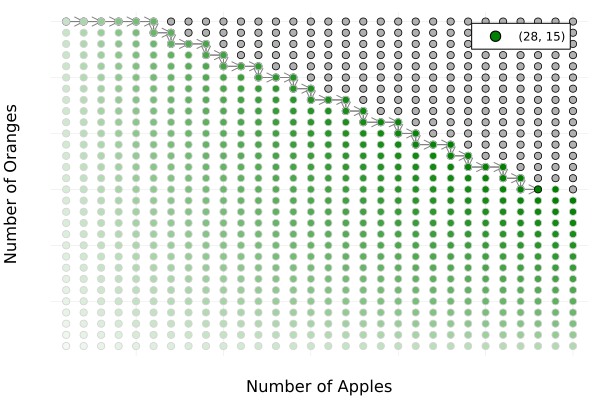

In [16]:
# draw the path -
p = plot();
initial_site = startstate
hit_absorbing_state = false
s = world_model.states[initial_site];
visited_sites = Set{Tuple{Int,Int}}();
push!(visited_sites, initial_site);

while (hit_absorbing_state == false)
    current_position = world_model.coordinates[s]
    a = my_π[s];
    Δ = world_model.moves[a];
    new_position =  current_position .+ Δ
    scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:blue)
    plot!([current_position[1], new_position[1]],[current_position[2],new_position[2]], label="", arrow=true, lw=1, c=:gray)
    
    if (in(new_position, absorbing_state_set) == true || in(new_position, visited_sites) == true)
        hit_absorbing_state = true;
    elseif (haskey(world_model.states, new_position) == true)
        s = world_model.states[new_position];
        push!(visited_sites, new_position);
    else
        hit_absorbing_state = true; # we drove off the map
    end
end

# draw the grid -
for s ∈ 𝒮
    current_position = world_model.coordinates[s]
    a = my_π[s];
    Δ = world_model.moves[a];
    new_position =  current_position .+ Δ
    
    if (haskey(rewards, current_position) == true && rewards[current_position] == my_objective_value)
        scatter!([current_position[1]],[current_position[2]], label="$(current_position)", showaxis=:false, c=:green, ms=4)
    elseif (in(current_position, soft_wall_set) == true)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:gray69, ms=4)
    else
        if (is_reward_shaping_on == true)
            theta = U(current_position,αvec)/my_objective_value;
            if theta > 1.0
                theta = 1.0
            end
            new_color = weighted_color_mean(theta, colorant"green", colorant"white")
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:lightgray, c=new_color)
        else
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:white)
        end
    end
end
current()
xlabel!("Number of Apples", fontsize=18)
ylabel!("Number of Oranges", fontsize=18)